In [1]:
import numpy as np
import pandas as pd
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

import prepare
import explore

import warnings
warnings.filterwarnings('ignore')

# GitHub README Natrual Language Processing Project
This project is designed to utilize language in READMEs to identify the primary language in a GitHub repository. 

---

## Executive Summary
Goals
- Utilize NLP to identify primary language of GitHub READMEs
- Build model to predict the primary language

Key Findings
- stuff
- things

Takeaways
- stuff
- things

Recommendations
- stuff
- things

----

## 1. Planning
 - Create deliverables:
     - README
     - final_report.ipynb
     - working_report.ipynb
     - 2-5 slides
     - video presentation
 - Finish the provided acquire.py and build functional prepare.py, explore.py and model.py files
 - Acquire the data from GitHub and save the json locally via the acquire.py
 - Prepare and split the data vis the prepare.py
 - Explore the data and define hypothesis. Run the appropriate statistical tests in order to accept or reject each null hypothesis. Document findings and takeaways.
 - Create a baseline model in predicting repository language and document using accuracy
 - Fit and train classification models to predict the primary language of each repository
 - Evaluate the models by comparing the train and validation data.
 - Select the best model and evaluate it on the test data.
 - Develop and document all findings, takeaways, recommendations and next steps.
----

## 2. Data Acquisition
In this step, I called my aquire.py. This function:
- web scrapes the data from GitHub
- creates a local JSON for ease of use

#### Data Dictionary
| Target | Type | Description |
| ---- | ---- | ---- |
| language | str | The primary coding language of the repository |

| Feature Name | Type | Description |
| ---- | ---- | ---- |
| repo | str | The repository name |
| readme_contents | str | The raw README text |
| readme_contents_clean | str | The cleaned and lemmatized README text |
| rm_length | int | The word count of the clean README text |
| sentiment | float | The compound sentiment value of the clean README text |

In [2]:
df = pd.read_json('data.json')

In [3]:
df.shape

(1000, 3)

### Data Acquisition Takeaways:
- The data returns 260 respository's READMEs over 3 features.
- The data used in this report was pulled on October 17, 2022

----

## 3. Data Preparation
In this step, I call my clean_df function from my prepare.py. This function:
- drops the 19 rows with nulls for language
- bins the language feature down to JavaScript, Python, Java, Ruby, and Other
- uses the Natural Language Toolkit to lemmitize the readme_content
    - basic clean
    - tokenize
    - lemmatize
    - remove stopwords
- feature engineers rm_length with a simple word count for each README
- feature engineers sentiment with the Sentiment Intensity Analyzer compound metric

In [4]:
df = prepare.clean_df(df,
              ['readme_contents'],
              'lemmatize',
              extra_words=['\'', 'td', '&#9', 'a', 'br', '&#9;', 'use'])

In [5]:
train, val, test = prepare.split_data(df)

### Data Preparation Takeaways:
- Narrowing down to specific languages vs an other category will assist modeling with less options to classify into
- Feature engineering rm_length and sentiment might give insight to more human features behind the langauges
- Data is split into train, validate, and test datasets to prepare for exploration and modeling
---

## 4. Data Exploration
- This exploration required some set up by creating long strings of all the words from READMEs for each language as well as a list for each. This resulted in a concatenated DataFrame called word_counts below.

In [6]:
all_words = ' '.join(train['readme_contents_clean'])
js_words = ' '.join(train[train.language == 'JavaScript']['readme_contents_clean'])
ja_words = ' '.join(train[train.language == 'Java']['readme_contents_clean'])
py_words = ' '.join(train[train.language == 'Python']['readme_contents_clean'])
ru_words = ' '.join(train[train.language == 'Ruby']['readme_contents_clean'])
ot_words = ' '.join(train[train.language == 'Other']['readme_contents_clean'])

In [7]:
all_freq = pd.Series(all_words.split()).value_counts()
js_freq = pd.Series(js_words.split()).value_counts()
ja_freq = pd.Series(ja_words.split()).value_counts()
py_freq = pd.Series(py_words.split()).value_counts()
ru_freq = pd.Series(ru_words.split()).value_counts()
ot_freq = pd.Series(ot_words.split()).value_counts()
word_counts = pd.concat([js_freq, ja_freq, py_freq, ru_freq, ot_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['JavaScript', 'Java', 'Python', 'Ruby', 'Other', 'All']

---
### Question 1: Does the length of the README vary by programming language?

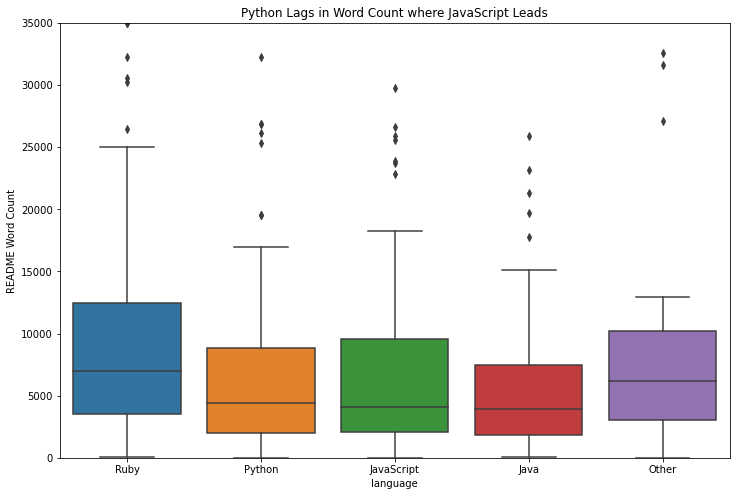

In [8]:
# show the visualizations for this question
explore.q1_vis(train)

#### Hypothesis 1:
- Ho2 -> READMEs for Java projects have more or equal number of words on average than the population.
- Ha2 -> READMEs for Java projects have less words on average than the population.

T-Test One-Sample, One-Tail

In [9]:
explore.q1_stats(train)

Reject the Null Hypothesis. 
    
Findings suggest Java projects use less words on average in their READMEs
than projects in other languages.


#### Question 1 Takeaways:
- Java READMEs use less words on average than the population
- Ruby has the widest spread of word count
- Other languages have the smallest spread of word count, and Java has the smallest spread for interquartile range

---
### Question 2: What are the most common words between languages?

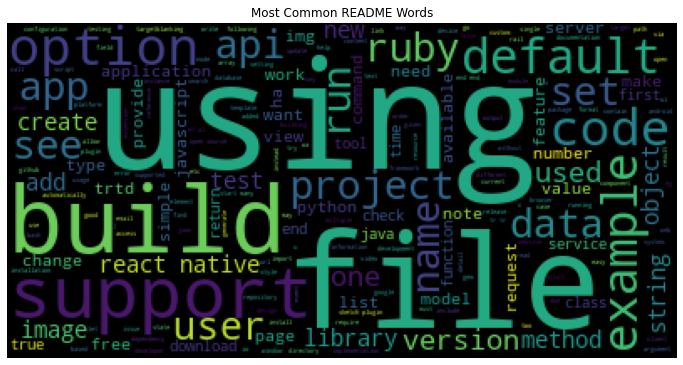

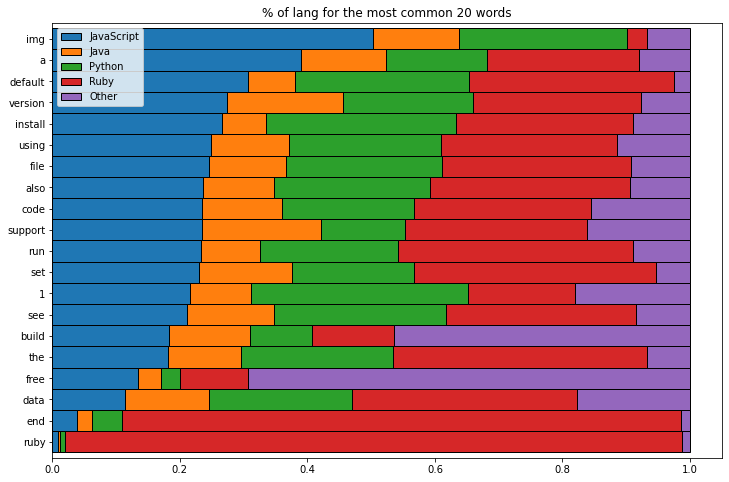

In [10]:
# show the visualizations for this question
explore.q2_vis(all_words, word_counts)

### Question 2b: What about bigrams?

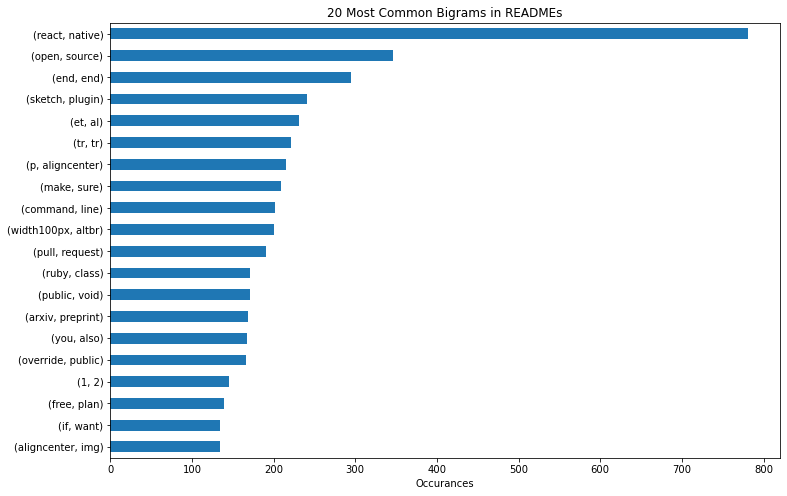

In [11]:
# show the visualizations for this question
explore.q2b_vis(all_words)

#### Question 2 Takeaways:
- Ruby READMEs highly use the word 'ruby' and 'end'
- It makes sense that words that apply to all languages appears across all READMEs

---
### Question 3: How do languages differ in sentiment within their README?

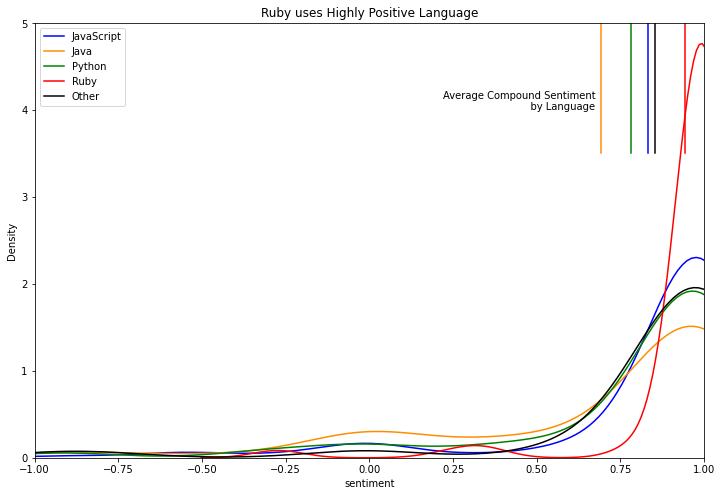

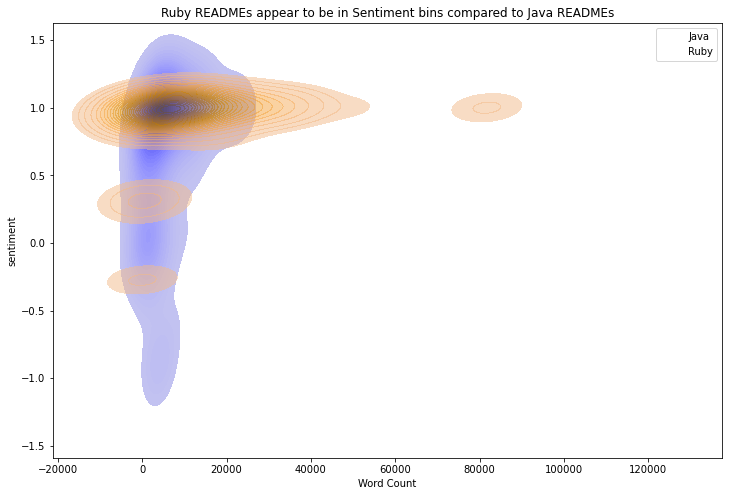

In [12]:
explore.q3_vis(train)

#### Hypothesis 3:
- Ho3 -> The average sentiment for Ruby READMEs is equal to or less than the average sentiment for Java READMEs.
- Ha3 -> The average sentiment for Ruby READMEs is higher than the average sentiment for Java READMEs.

T-Test Two-Sample, One-Tail

In [13]:
explore.q3_stats(train)

Reject the Null Hypothesis.

Findings suggest the average sentiment for Ruby READMEs is
higher than the average sentiment for Java READMEs


#### Question 3 Takeaways:
- Ruby's average compound sentiment is higher than's Java's
- Ruby's sentiment appears to fall into bins at -.25, .25, and 1 on the sentiment scale where the higher the word count, the more positive the sentiment
- All languages show heavily positive compound sentiment
- A possible explanation is that those that use more words in their README could be the most happy or satisfied with their project

---
### 5. Modeling